# Task 6 - Project work

### 1. Introduction & Objectives

In this project, we aim to create a classification model that predicts the likelihood of loan approval based on various financial and personal factors of loan applicants. We'll first explore decision trees for transparency, followed by random forests to improve model performance.

### 2. Understanding the Data

#### Loading the data and a quick preview
We will load the data sheet

First let's take a peak at the data and see what it looks like in its raw form:

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Load the dataset
df = pd.read_csv("../Datasets/loan_approval_dataset.csv")


In [11]:
# Display basic information about the dataset
df.info()

# Display the first few rows of the dataset
df.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


Here we can see the total entries is 4269 which represent invidual loan applications. Also there is a total of 13 columns that represents different features of the loan applicants.

Let's check if there is any null values points.

In [12]:
missing_values = df.isnull().sum()
missing_values

loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

As we can see, the data is clean so we can move onwards. Let's start plotting the data.

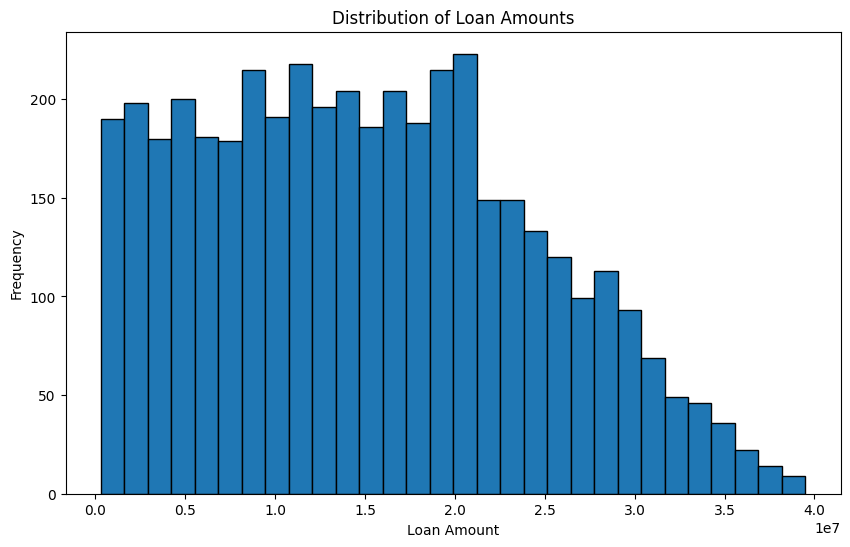

In [26]:
plt.figure(figsize=(10, 6))
df[' loan_amount'].plot(kind='hist', bins=30, edgecolor='black')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Loan Amounts')
plt.show()

The results shows us that the loan amounts between 0.3 - 2.0 (millions) are the most frequently applied for. However this isn't exactly the key feature we are looking for, but we can still process this even further to see if this is truly the case by comparing loan amount to the loan status.

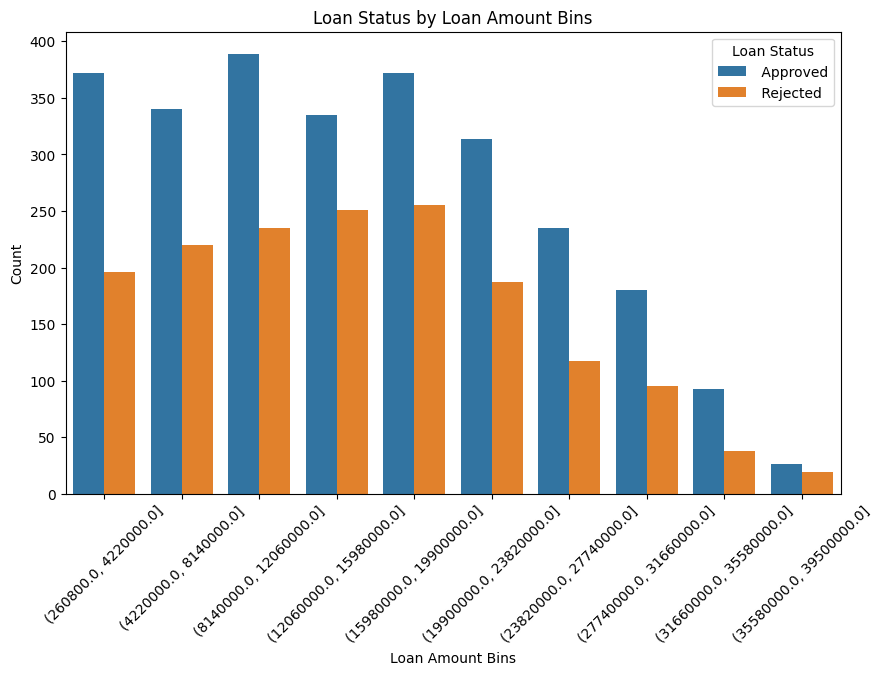

In [39]:

df['loan_amount_bins'] = pd.cut(df[' loan_amount'], bins=10)


plt.figure(figsize=(10, 6))
sns.countplot(x='loan_amount_bins', hue=' loan_status', data=df)
plt.title('Loan Status by Loan Amount Bins')
plt.xlabel('Loan Amount Bins')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.xticks(rotation=45)
plt.show()

The loan amount can be ruled out at this point, since we notice the amount doesn't affect the outcome of loan approval. Moving on to analyze the loan count and see how many how the applications got approved and how many rejected.

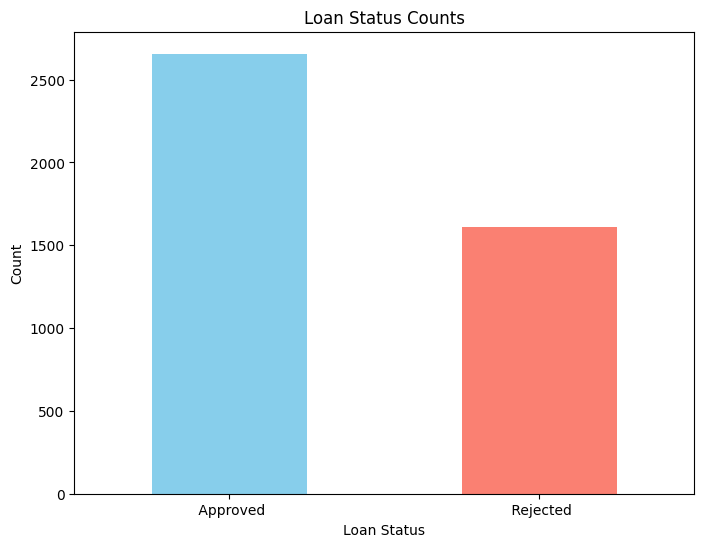

In [40]:

plt.figure(figsize=(8, 6))
df[' loan_status'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Loan Status Counts')
plt.xticks(rotation=0)
plt.show()


Over 50% got approved of the total loan counts.

<Figure size 1000x600 with 0 Axes>

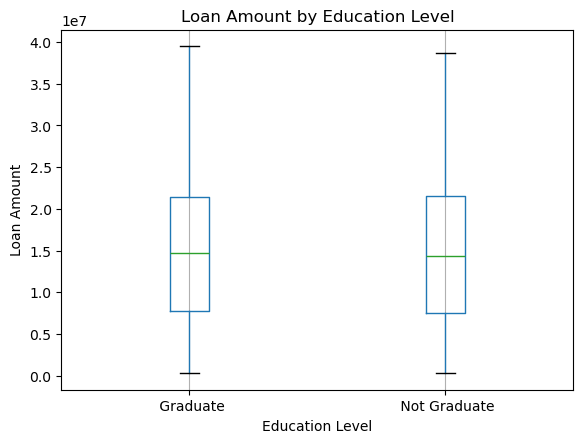

In [5]:
plt.figure(figsize=(10, 6))
df.boxplot(column=' loan_amount', by=' education')
plt.xlabel('Education Level')
plt.ylabel('Loan Amount')
plt.title('Loan Amount by Education Level')
plt.suptitle('')  
plt.grid(axis='y')
plt.show()


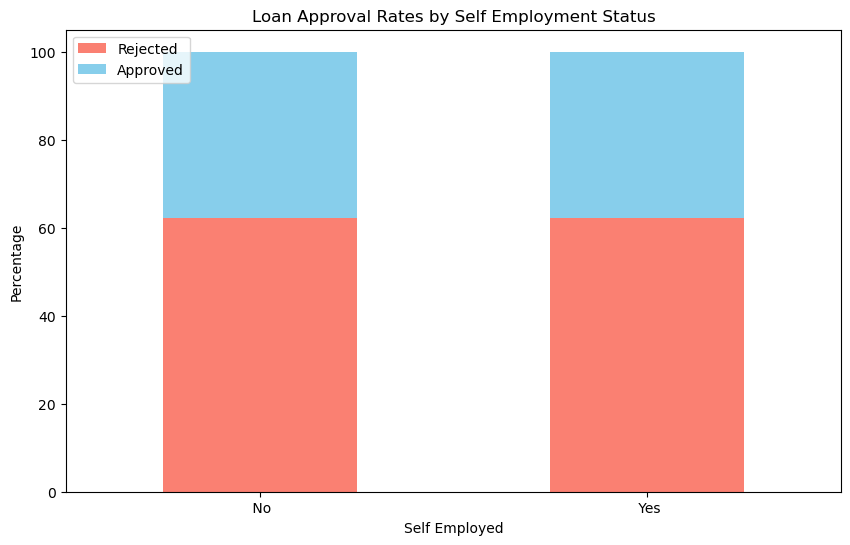

In [56]:
loan_approval_by_self_employed = df.groupby(' self_employed')[' loan_status'].value_counts(normalize=True).unstack() * 100
loan_approval_by_self_employed.plot(kind='bar', stacked=True, figsize=(10, 6), color=['salmon', 'skyblue'])
plt.xlabel('Self Employed')
plt.ylabel('Percentage')
plt.title('Loan Approval Rates by Self Employment Status')
plt.legend(['Rejected', 'Approved'], loc='upper left')
plt.xticks(rotation=0)
plt.show()


Let's analyze CIBIL Score and it's affection for the Loan Status. We will be using a Strip Plot. Explanation:

Using sns.stripplot: The stripplot function allows for jittering, which helps to spread the points horizontally, preventing overlap and making it clearer how many loans were approved or rejected at each score level.

Dodge and Jitter: The parameters dodge=True and jitter=True help to separate the data points for better visibility. size=6 sets the size of the markers to make them more distinguishable.

Threshold Lines: The vertical lines at CIBIL scores of 550 and 600 remain, visually indicating the significant points in the CIBIL score range.

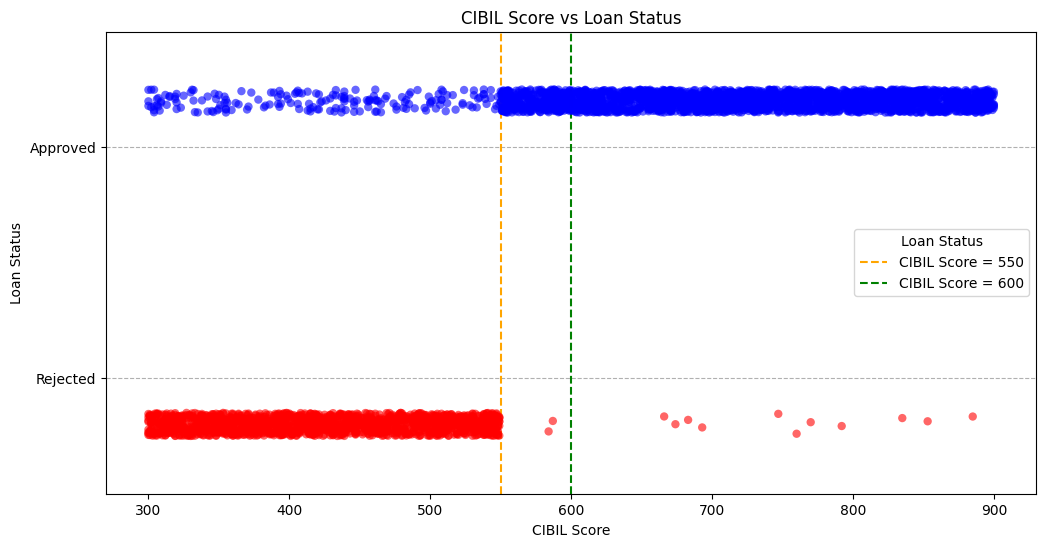

In [65]:
df.columns = df.columns.str.strip()
df['loan_status'] = df['loan_status'].str.strip()


plt.figure(figsize=(12, 6))


sns.stripplot(data=df, x='cibil_score', y='loan_status', hue='loan_status',
               palette={"Approved": "blue", "Rejected": "red"},
               dodge=True, alpha=0.6, jitter=True, marker='o', edgecolor='w', size=6)

plt.axvline(x=550, color='orange', linestyle='--', label='CIBIL Score = 550')
plt.axvline(x=600, color='green', linestyle='--', label='CIBIL Score = 600')


plt.title('CIBIL Score vs Loan Status')
plt.xlabel('CIBIL Score')
plt.ylabel('Loan Status')
plt.legend(title='Loan Status')
plt.grid(axis='y', linestyle='--')
plt.show()


As we can see, clearly the inviduals that seeked for loan with CIBIL Score of under 550 are more common to get Rejected, compared to the ones with CIBIL Score higher than 550. Let's analyze this feature more.

<Figure size 1000x600 with 0 Axes>

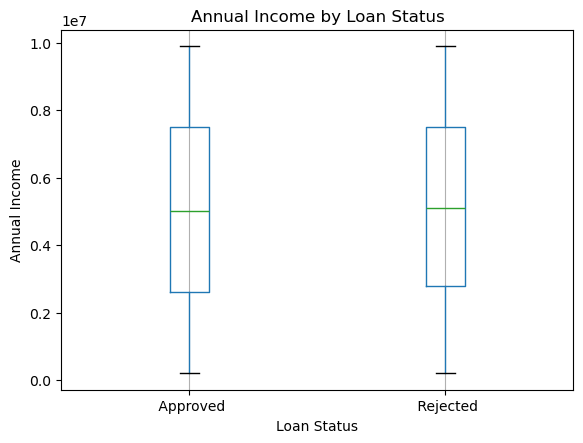

In [58]:
plt.figure(figsize=(10, 6))
df.boxplot(column=' income_annum', by=' loan_status')
plt.xlabel('Loan Status')
plt.ylabel('Annual Income')
plt.title('Annual Income by Loan Status')
plt.suptitle('')  
plt.grid(axis='y')
plt.show()


### 3. Data preparation

In [21]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the categorical variables
df[' education'] = label_encoder.fit_transform(df[' education'])
df[' self_employed'] = label_encoder.fit_transform(df[' self_employed'])


In [24]:
# Select numerical features
numerical_features = [' income_annum', ' loan_amount', ' loan_term', ' cibil_score', 
                      ' residential_assets_value', ' commercial_assets_value', 
                      ' luxury_assets_value', ' bank_asset_value']

# Initialize the scaler
scaler = StandardScaler()

# Scale the numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Define features and target variable
X = df.drop(' loan_status', axis=1)
y = df[' loan_status']

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (3415, 12) (3415,)
Testing set shape: (854, 12) (854,)


### 4 Modeling

In [25]:
# Initialize the logistic regression model
model_with_cibil = LogisticRegression(max_iter=1000)

# Train the model with all features
model_with_cibil.fit(X_train, y_train)

# Predict on the test set
y_pred_with_cibil = model_with_cibil.predict(X_test)

In [26]:
# Evaluate the model with CIBIL score
print("Model with CIBIL Score")
print("Accuracy:", accuracy_score(y_test, y_pred_with_cibil))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_with_cibil))
print("Classification Report:\n", classification_report(y_test, y_pred_with_cibil))


Model with CIBIL Score
Accuracy: 0.9074941451990632
Confusion Matrix:
 [[500  36]
 [ 43 275]]
Classification Report:
               precision    recall  f1-score   support

    Approved       0.92      0.93      0.93       536
    Rejected       0.88      0.86      0.87       318

    accuracy                           0.91       854
   macro avg       0.90      0.90      0.90       854
weighted avg       0.91      0.91      0.91       854



In [28]:
# Remove the CIBIL score from the features
X_train_no_cibil = X_train.drop(' cibil_score', axis=1)
X_test_no_cibil = X_test.drop(' cibil_score', axis=1)

# Initialize the logistic regression model
model_without_cibil = LogisticRegression(max_iter=1000)

# Train the model without the CIBIL score
model_without_cibil.fit(X_train_no_cibil, y_train)

# Predict on the test set without CIBIL score
y_pred_without_cibil = model_without_cibil.predict(X_test_no_cibil)


In [29]:
# Evaluate the model without CIBIL score
print("Model without CIBIL Score")
print("Accuracy:", accuracy_score(y_test, y_pred_without_cibil))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_without_cibil))
print("Classification Report:\n", classification_report(y_test, y_pred_without_cibil))


Model without CIBIL Score
Accuracy: 0.6252927400468384
Confusion Matrix:
 [[507  29]
 [291  27]]
Classification Report:
               precision    recall  f1-score   support

    Approved       0.64      0.95      0.76       536
    Rejected       0.48      0.08      0.14       318

    accuracy                           0.63       854
   macro avg       0.56      0.52      0.45       854
weighted avg       0.58      0.63      0.53       854



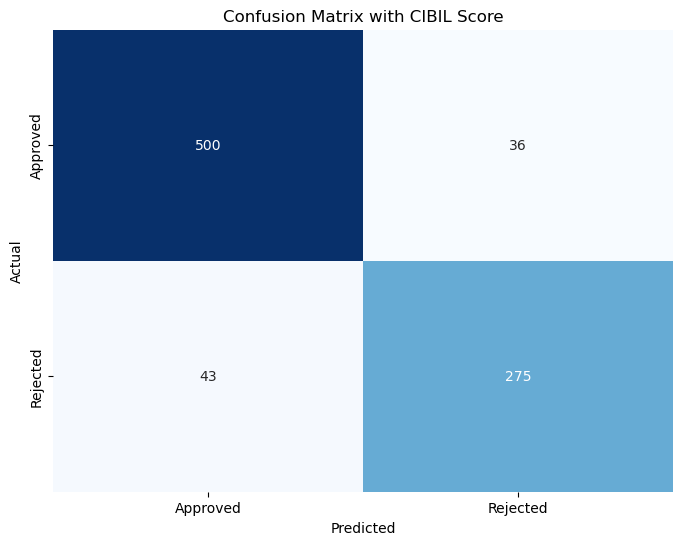

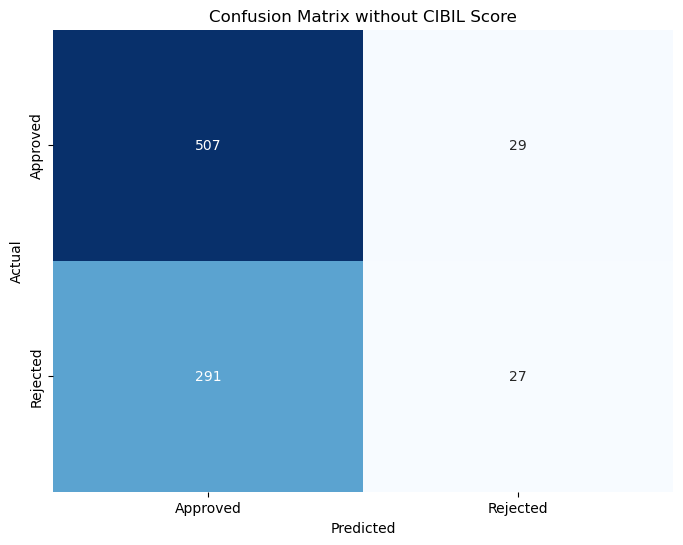

In [30]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=["Approved", "Rejected"], 
                yticklabels=["Approved", "Rejected"])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrices for both models
plot_confusion_matrix(y_test, y_pred_with_cibil, "Confusion Matrix with CIBIL Score")
plot_confusion_matrix(y_test, y_pred_without_cibil, "Confusion Matrix without CIBIL Score")

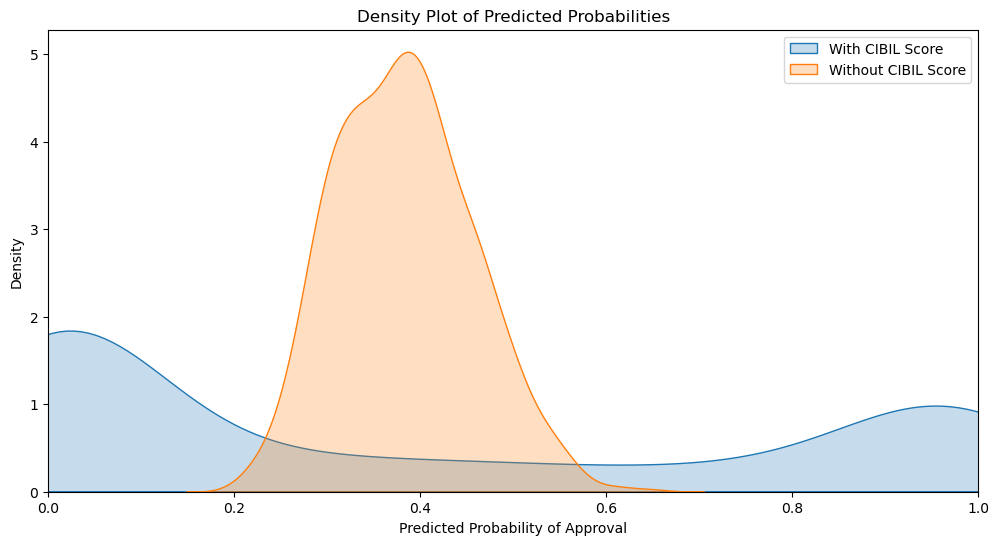

In [56]:
# Predict probabilities for both models
probs_with_cibil = model_with_cibil.predict_proba(X_test)[:, 1]  # Probability of approval
probs_without_cibil = model_without_cibil.predict_proba(X_test_no_cibil)[:, 1]

pred_probs_df = pred_probs_df[(pred_probs_df['Probability with CIBIL Score'] >= 0) & 
                               (pred_probs_df['Probability with CIBIL Score'] <= 1) & 
                               (pred_probs_df['Probability without CIBIL Score'] >= 0) & 
                               (pred_probs_df['Probability without CIBIL Score'] <= 1)]

# Plot the predicted probabilities after filtering
plt.figure(figsize=(12, 6))
sns.kdeplot(pred_probs_df['Probability with CIBIL Score'], label='With CIBIL Score', fill=True)
sns.kdeplot(pred_probs_df['Probability without CIBIL Score'], label='Without CIBIL Score', fill=True)
plt.title('Density Plot of Predicted Probabilities')
plt.xlabel('Predicted Probability of Approval')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1)  # Limit the x-axis to valid probability range
plt.show()


With CIBIL Score (Blue Line):

The density is relatively standard or narrow, showing that most predicted probabilities are concentrated in a specific range. This suggests that the model is consistent in its predictions when the CIBIL score is included.
There seems to be a peak around 0.4, indicating that a significant number of loan applications are predicted to have a 40% chance of approval, with fewer applications predicted to be closer to 0 or 1.
Without CIBIL Score 

(Orange Line):

The density is much wider and has a different shape, indicating more variability in the predicted probabilities. This suggests that the model makes less consistent predictions without the CIBIL score.
The large peak indicates that there is a significant number of predictions clustering at the lower probability ranges (around 0.2-0.4) and a tail extending toward the higher probabilities, but fewer predictions at those extremes compared to when the CIBIL score is included.

In [41]:
# Initialize the Decision Tree Classifier
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)

# Fit the model to the training data
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=3, random_state=42)

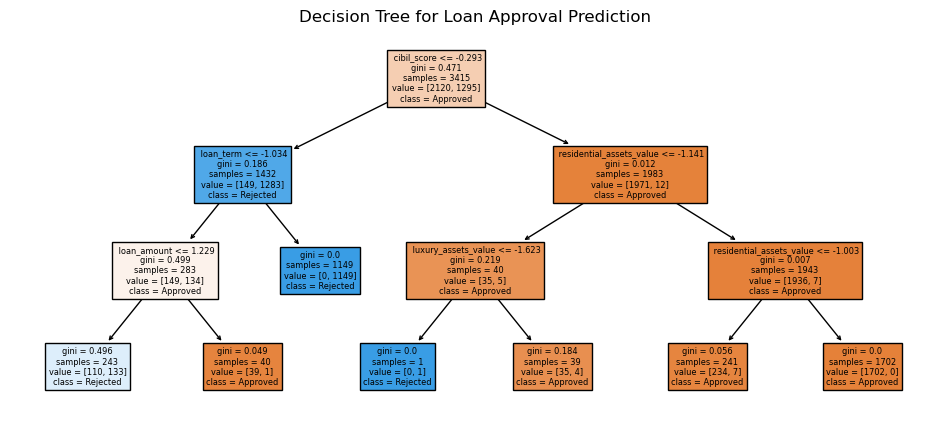

In [42]:
# Plot the decision tree
plt.figure(figsize=(12, 5))
plot_tree(dt_model, feature_names=X_train.columns, class_names=['Approved', 'Rejected'], filled=True)
plt.title("Decision Tree for Loan Approval Prediction")
plt.show()


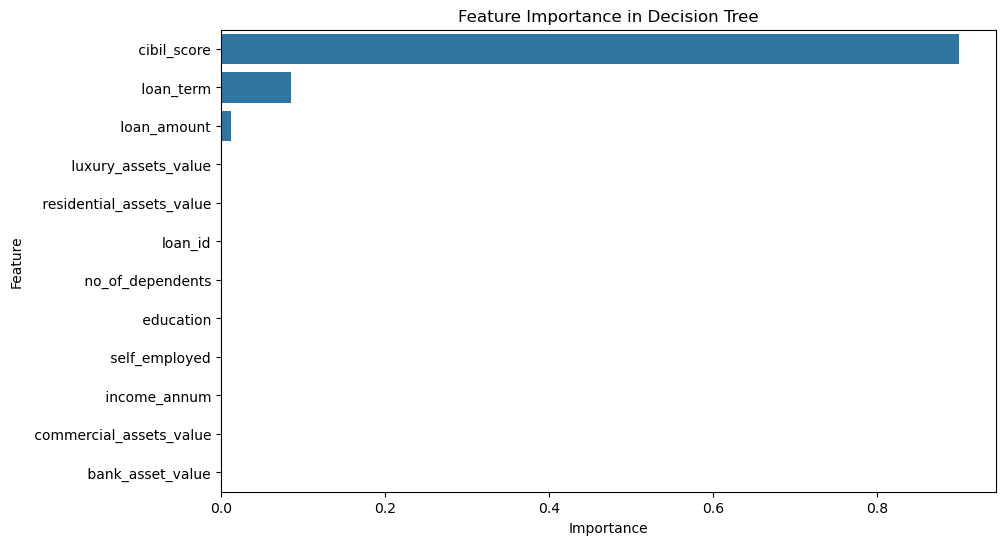

In [43]:
# Get feature importances
importances = dt_model.feature_importances_
features = X_train.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title("Feature Importance in Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [46]:
# Make predictions
y_pred_pruned = dt_model.predict(X_test)

# Evaluate the pruned model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_pruned))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_pruned))


Confusion Matrix:
[[509  27]
 [  3 315]]

Classification Report:
              precision    recall  f1-score   support

    Approved       0.99      0.95      0.97       536
    Rejected       0.92      0.99      0.95       318

    accuracy                           0.96       854
   macro avg       0.96      0.97      0.96       854
weighted avg       0.97      0.96      0.97       854



In [48]:
# Generate predictions for both models
y_pred_logistic = model_with_cibil.predict(X_test)
y_pred_pruned = dt_model.predict(X_test)


In [49]:
# Confusion Matrix for Logistic Regression
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
print("Confusion Matrix for Logistic Regression:")
print(cm_logistic)

# Confusion Matrix for Pruned Decision Tree
cm_pruned = confusion_matrix(y_test, y_pred_pruned)
print("\nConfusion Matrix for Pruned Decision Tree:")
print(cm_pruned)

Confusion Matrix for Logistic Regression:
[[500  36]
 [ 43 275]]

Confusion Matrix for Pruned Decision Tree:
[[509  27]
 [  3 315]]


In [50]:
# Classification Report for Logistic Regression
report_logistic = classification_report(y_test, y_pred_logistic)
print("\nClassification Report for Logistic Regression:")
print(report_logistic)

# Classification Report for Pruned Decision Tree
report_pruned = classification_report(y_test, y_pred_pruned)
print("\nClassification Report for Pruned Decision Tree:")
print(report_pruned)


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

    Approved       0.92      0.93      0.93       536
    Rejected       0.88      0.86      0.87       318

    accuracy                           0.91       854
   macro avg       0.90      0.90      0.90       854
weighted avg       0.91      0.91      0.91       854


Classification Report for Pruned Decision Tree:
              precision    recall  f1-score   support

    Approved       0.99      0.95      0.97       536
    Rejected       0.92      0.99      0.95       318

    accuracy                           0.96       854
   macro avg       0.96      0.97      0.96       854
weighted avg       0.97      0.96      0.97       854



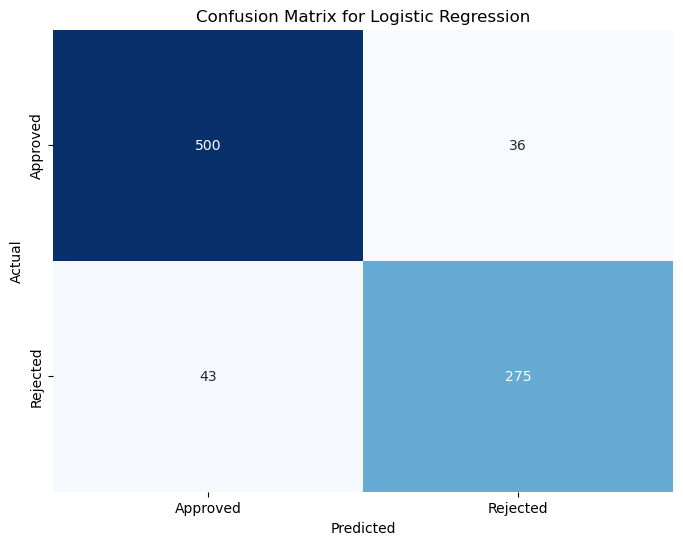

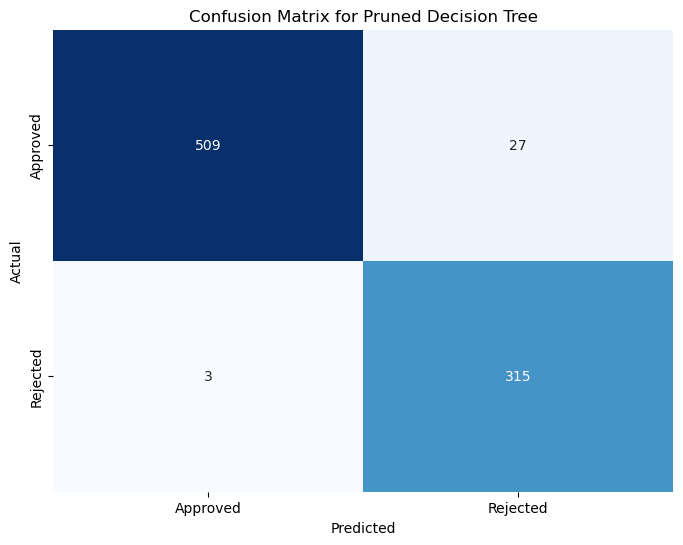

In [51]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Approved', 'Rejected'], 
                yticklabels=['Approved', 'Rejected'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(cm_logistic, 'Logistic Regression')
plot_confusion_matrix(cm_pruned, 'Pruned Decision Tree')